<a href="https://colab.research.google.com/github/namita0210/Text-Sentiment-Classifier/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from kagglehub import dataset_download
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as lemmy
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') # It uses the perceptron algorithm to assign parts of speech to words based on context.
nltk.download('punkt') # for tokenizing text to words or sentences
nltk.download('stopwords') # populary removed words
nltk.download('wordnet') #dictionary of words to reduce them to their base form : lemmatize
nltk.download('averaged_perceptron_tagger')  # For POS tagging

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
# Download latest version
path = dataset_download("jp797498e/twitter-entity-sentiment-analysis")
print("Path to dataset files:", path)

100%|██████████| 1.99M/1.99M [00:00<00:00, 91.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2


In [3]:
train_df = pd.read_csv(path + '/twitter_training.csv' , header = None)
val_df = pd.read_csv(path + '/twitter_validation.csv', header = None)
train_df.columns = ['id','title','sentiment','text']
val_df.columns = ['id','title','sentiment','text']

In [4]:
train_df.shape

(74682, 4)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   title      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
val_df.shape

(1000, 4)

In [7]:
train_df.dropna(subset=['text'], inplace=True)

In [8]:
train_df

,id,title,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [9]:
val_df

,id,title,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [10]:
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

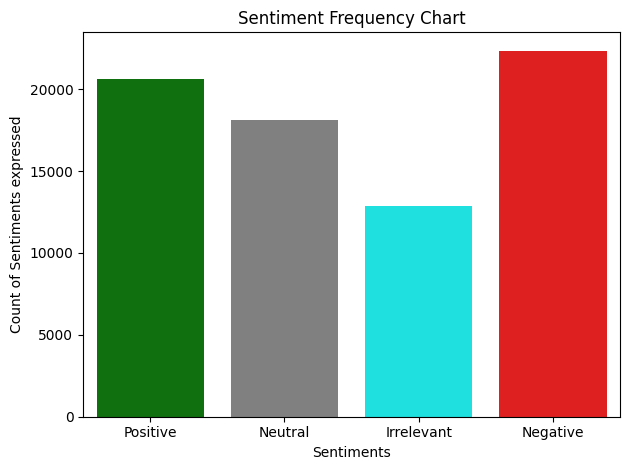

In [11]:
color = {'Positive':'Green', 'Neutral':'Grey', 'Irrelevant':'Cyan','Negative':'Red'}
sns.countplot(x='sentiment', data=train_df
              , order=['Positive','Neutral','Irrelevant','Negative']
              ,hue='sentiment'
              ,legend=False
              ,palette=color)
plt.xlabel('Sentiments')
plt.ylabel('Count of Sentiments expressed')
plt.title('Sentiment Frequency Chart')
plt.tight_layout()
plt.show()

In [12]:
stop_words = set(stopwords.words('english'))
lm = lemmy()

def clean(text):
    text=text.lower() #lowercase

    no_punct = re.sub(r'[^a-z\s]','',text) #remove punctuation, digits

    words = word_tokenize(no_punct) #split text into words, returns a list

    words = [i for i in words if i not in stop_words] #remove stopwords

    pos_tags = nltk.pos_tag(words) # returns a tuple (word, pos tag)
    words = [
    lm.lemmatize(word, pos='v') if tag.startswith('V') else  # If tag starts with 'V', treat as verb
    lm.lemmatize(word, pos='n') if tag.startswith('N') else  # If tag starts with 'N', treat as noun
    lm.lemmatize(word, pos='a') if tag.startswith('R') else  # If tag starts with 'R', treat as adjective/adverb
    lm.lemmatize(word)  # Default to noun if no match
    for word, tag in pos_tags
    ] #lemmatize returns a string

    clean_words = ' '.join(words) # joins the words in the list seperated by a space

    return clean_words

In [13]:
train_df['text']=train_df['text'].apply(clean)

In [14]:
train_df

,id,title,sentiment,text
0,2401,Borderlands,Positive,im get borderland murder
1,2401,Borderlands,Positive,come border kill
2,2401,Borderlands,Positive,im get borderland kill
3,2401,Borderlands,Positive,im come borderland murder
4,2401,Borderlands,Positive,im get borderland murder
...,...,...,...,...
74677,9200,Nvidia,Positive,realize window partition mac like year behind ...
74678,9200,Nvidia,Positive,realize mac window partition year behind nvidi...
74679,9200,Nvidia,Positive,realize window partition mac year behind nvidi...
74680,9200,Nvidia,Positive,realize window partition mac like year behind ...


In [15]:
train_df['text'].apply(word_tokenize)

,text
0,"[im, get, borderland, murder]"
1,"[come, border, kill]"
2,"[im, get, borderland, kill]"
3,"[im, come, borderland, murder]"
4,"[im, get, borderland, murder]"
...,...
74677,"[realize, window, partition, mac, like, year, ..."
74678,"[realize, mac, window, partition, year, behind..."
74679,"[realize, window, partition, mac, year, behind..."
74680,"[realize, window, partition, mac, like, year, ..."


In [16]:
vectorizer = TfidfVectorizer()

In [17]:
X = vectorizer.fit_transform(train_df['text'])

In [18]:
X

<73996x34526 sparse matrix of type '<class 'numpy.float64'>'
	with 743446 stored elements in Compressed Sparse Row format>

In [34]:
type(X)

scipy.sparse._csr.csr_matrix

In [35]:
print(X)

  (0, 14111)	0.3596450088186696
  (0, 11120)	0.3141815004193741
  (0, 3369)	0.4882627301386867
  (0, 18983)	0.7304416190111062
  (1, 5303)	0.429303324399671
  (1, 3367)	0.7531625149777598
  (1, 15892)	0.49844245574766877
  (2, 14111)	0.4242645436030371
  (2, 11120)	0.37063233915516414
  (2, 3369)	0.5759917676630613
  (2, 15892)	0.5923383744094753
  (3, 14111)	0.34474311825658266
  (3, 3369)	0.46803156442899924
  (3, 18983)	0.7001757712957407
  (3, 5303)	0.4145509937309115
  (4, 14111)	0.3596450088186696
  (4, 11120)	0.3141815004193741
  (4, 3369)	0.4882627301386867
  (4, 18983)	0.7304416190111062
  (5, 14111)	0.3596450088186696
  (5, 11120)	0.3141815004193741
  (5, 3369)	0.4882627301386867
  (5, 18983)	0.7304416190111062
  (6, 3369)	0.14965454852918428
  (6, 27506)	0.21403659779649029
  :	:
  (73993, 21156)	0.44608694946484423
  (73994, 16710)	0.15422037969416202
  (73994, 33691)	0.18570713967163852
  (73994, 10558)	0.16632879115002533
  (73994, 8944)	0.20183599547291814
  (73994, 2423

Most of the elements in a TF-IDF matrix are typically zero (because most words don't appear in most documents).  Storing all those zeros would be extremely inefficient.  Sparse matrix formats like COO, Compressed Sparse Row (CSR), and Compressed Sparse Column (CSC) only store the non-zero values and their indices, saving a huge amount of memory.

In [19]:
sentiment_map = {
    'Positive': 3,
    'Neutral': 1,
    'Irrelevant': 2,
    'Negative': 0
}

In [20]:
train_df['sentiment'] = train_df['sentiment'].map(sentiment_map)

In [21]:
len(train_df['title'].unique())

32

In [22]:
le = LabelEncoder()
train_df['title'] = le.fit_transform(train_df['title'])

In [23]:
num_categories = len(train_df['title'].unique())

In [24]:
embedding_dim = 5

In [25]:
nn = Sequential()

In [26]:
nn.add(Embedding(input_dim=num_categories,  # 32 categories
                    output_dim=embedding_dim,  # Dimension of the embedding vector (e.g., 5)
                    input_length=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
nn.add(Flatten())

In [28]:
nn.add(Dense(64, activation='relu'))  # Hidden layer with 64 neurons
nn.add(Dense(32, activation='relu'))

In [29]:
nn.add(Dense(4, activation='softmax'))  # Output layer with 4 classes (0-3)

In [30]:
# Compile the model
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [31]:
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
nn.fit(train_df['title'], train_df['sentiment'], epochs=10, batch_size=32)

Epoch 1/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3886 - loss: 1.2863
Epoch 2/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4163 - loss: 1.2490
Epoch 3/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4155 - loss: 1.2511
Epoch 4/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.4167 - loss: 1.2469
Epoch 5/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4152 - loss: 1.2478
Epoch 6/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4145 - loss: 1.2514
Epoch 7/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4145 - loss: 1.2499
Epoch 8/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4143 - loss: 1.2498
Epoch 9/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4133 - loss: 1.2494
Epoch 10/10
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4171 - loss: 1.2460
